This notebook merges best practices from refactored training and original prediction code.
It uses MobileNetV2 for binary classification (fresh vs rotten), includes data visualization,
and a friendly prediction + CSV export interface for real-world application.

In [73]:
# 📦 0. Google Drive Setup and Dataset Extraction
from google.colab import drive
import os
import shutil

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
else:
    print("Google Drive is already mounted.")

# Extract dataset
!rm -rf /content/dataset
!unzip -q -o "/content/drive/MyDrive/FRESHQ_PROJECT/FreshandRottenClassification.zip" -d /content/dataset
!ls /content/dataset/dataset

Google Drive is already mounted.
Test  Train


In [74]:
# 🔄 1. Reorganize Multiclass Dataset to Binary (fresh/rotten)
ORIGINAL_TRAIN_DIR = "/content/dataset/dataset/Train"
ORIGINAL_TEST_DIR = "/content/dataset/dataset/Test"
NEW_TRAIN_DIR = "/content/dataset/binary/Train"
NEW_TEST_DIR = "/content/dataset/binary/Test"

for new_dir in [NEW_TRAIN_DIR + "/fresh", NEW_TRAIN_DIR + "/rotten", NEW_TEST_DIR + "/fresh", NEW_TEST_DIR + "/rotten"]:
    os.makedirs(new_dir, exist_ok=True)

def reorganize_images(original_dir, new_dir):
    for subfolder in os.listdir(original_dir):
        subfolder_path = os.path.join(original_dir, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        target_class = "fresh" if "fresh" in subfolder.lower() else "rotten"
        target_dir = os.path.join(new_dir, target_class)
        for img_name in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, img_name)
            if os.path.isfile(img_path):
                shutil.copy(img_path, os.path.join(target_dir, f"{subfolder}_{img_name}"))

reorganize_images(ORIGINAL_TRAIN_DIR, NEW_TRAIN_DIR)
reorganize_images(ORIGINAL_TEST_DIR, NEW_TEST_DIR)

# 👁️ Count images per class
for split, new_dir in [("Train", NEW_TRAIN_DIR), ("Test", NEW_TEST_DIR)]:
    fresh_count = len(os.listdir(os.path.join(new_dir, "fresh")))
    rotten_count = len(os.listdir(os.path.join(new_dir, "rotten")))
    print(f"{split} - Fresh images: {fresh_count}, Rotten images: {rotten_count}")

Train - Fresh images: 11200, Rotten images: 12419
Test - Fresh images: 3245, Rotten images: 3493


In [75]:
# 🧪 2. Data Generators and Augmentation
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 12
TRAIN_DIR = "/content/dataset/binary/Train"
TEST_DIR = "/content/dataset/binary/Test"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)
print("Class indices:", train_generator.class_indices)

Found 18896 images belonging to 2 classes.
Found 4723 images belonging to 2 classes.
Found 6738 images belonging to 2 classes.
Class indices: {'fresh': 0, 'rotten': 1}


In [76]:
# 🧠 3. Model Setup (MobileNetV2)
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [77]:
# 🎯 4. Training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model_binary.h5', save_best_only=True)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=200,
    validation_steps=50,
    epochs=EPOCHS,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.7140 - loss: 0.5476

200/200 ━━━━━━━━━━━━━━━━━━━━ 137s 641ms/step - accuracy: 0.7144 - loss: 0.5469 - val_accuracy: 0.8000 - val_loss: 0.3893
Epoch 2/12
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.8925 - loss: 0.2609

200/200 ━━━━━━━━━━━━━━━━━━━━ 119s 597ms/step - accuracy: 0.8926 - loss: 0.2609 - val_accuracy: 0.8838 - val_loss: 0.2687
Epoch 3/12
191/200 ━━━━━━━━━━━━━━━━━━━━ 4s 460ms/step - accuracy: 0.9133 - loss: 0.2234

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


200/200 ━━━━━━━━━━━━━━━━━━━━ 139s 701ms/step - accuracy: 0.9133 - loss: 0.2232 - val_accuracy: 0.8719 - val_loss: 0.2843
Epoch 4/12
200/200 ━━━━━━━━━━━━━━━━━━━━ 201s 747ms/step - accuracy: 0.9232 - loss: 0.1956 - val_accuracy: 0.8500 - val_loss: 0.3573
Epoch 5/12
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.9269 - loss: 0.1803

200/200 ━━━━━━━━━━━━━━━━━━━━ 143s 718ms/step - accuracy: 0.9270 - loss: 0.1803 - val_accuracy: 0.9025 - val_loss: 0.2376
Epoch 6/12
200/200 ━━━━━━━━━━━━━━━━━━━━ 142s 713ms/step - accuracy: 0.9325 - loss: 0.1723 - val_accuracy: 0.8913 - val_loss: 0.2484
Epoch 7/12
200/200 ━━━━━━━━━━━━━━━━━━━━ 112s 561ms/step - accuracy: 0.9431 - loss: 0.1550 - val_accuracy: 0.8950 - val_loss: 0.2644
Epoch 8/12
200/200 ━━━━━━━━━━━━━━━━━━━━ 142s 715ms/step - accuracy: 0.9478 - loss: 0.1381 - val_accuracy: 0.8919 - val_loss: 0.2499
Epoch 9/12
200/200 ━━━━━━━━━━━━━━━━━━━━ 142s 714ms/step - accuracy: 0.9529 - loss: 0.1285 - val_accuracy: 0.8994 - val_loss: 0.2462
Epoch 10/12
200/200 ━━━━━━━━━━━━━━━━━━━━ 202s 786ms/step - accuracy: 0.9578 - loss: 0.1268 - val_accuracy: 0.8938 - val_loss: 0.2534


211/211 ━━━━━━━━━━━━━━━━━━━━ 35s 166ms/step - accuracy: 0.8916 - loss: 0.2536
Test Accuracy: 92.00%


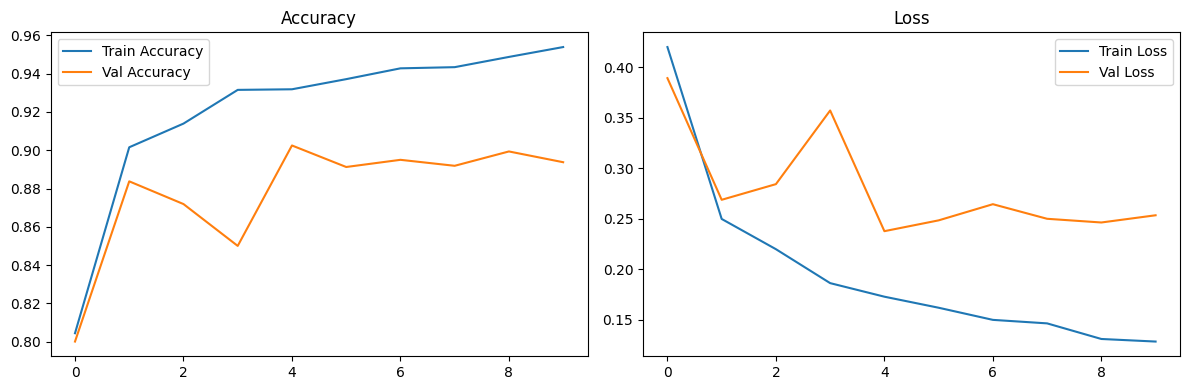

In [78]:
# 📊 5. Evaluation
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc:.2%}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()

211/211 ━━━━━━━━━━━━━━━━━━━━ 35s 153ms/step

Classification Report:

              precision    recall  f1-score   support

       fresh       0.94      0.89      0.91      3245
      rotten       0.90      0.95      0.92      3493

    accuracy                           0.92      6738
   macro avg       0.92      0.92      0.92      6738
weighted avg       0.92      0.92      0.92      6738



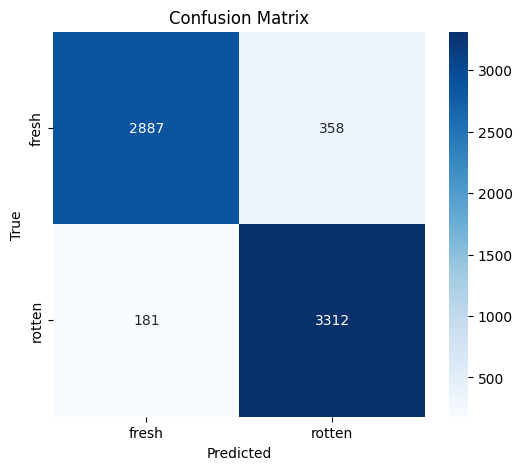

In [79]:
# 📈 Confusion Matrix + Report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_true = test_generator.classes
y_pred = (model.predict(test_generator) > 0.5).astype(int).reshape(-1)

labels = ['fresh', 'rotten']

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels))

conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [82]:
# 💾 6. Save and Export Model
model.save('freshq_binary_final.h5')
from google.colab import files
files.download('freshq_binary_final.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


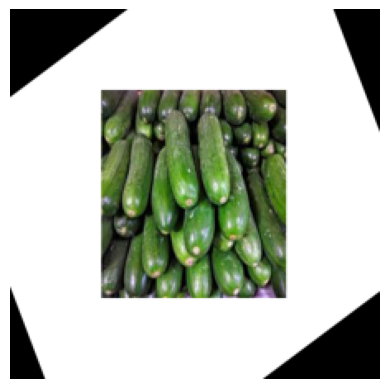

Model Prediction : Fresh (98.32%)


In [83]:
from PIL import Image
import io
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import sys
import contextlib

# Set your model's expected input size
IMG_SIZE = (224, 224)  # Change if needed

def predict_uploaded_images():
    # Suppress upload messages
    with contextlib.redirect_stdout(sys.__stdout__):
        uploaded = files.upload()

    for filename in uploaded.keys():
        # Load and preprocess image
        img = Image.open(io.BytesIO(uploaded[filename])).resize(IMG_SIZE)
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Predict
        prediction = model.predict(img_array)[0][0]
        label = "Rotten" if prediction > 0.5 else "Fresh"
        confidence = prediction if prediction > 0.5 else 1 - prediction

        # Show image
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        # Print result
        print(f"Model Prediction : {label} ({confidence * 100:.2f}%)")

# Run this to upload and predict
predict_uploaded_images()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


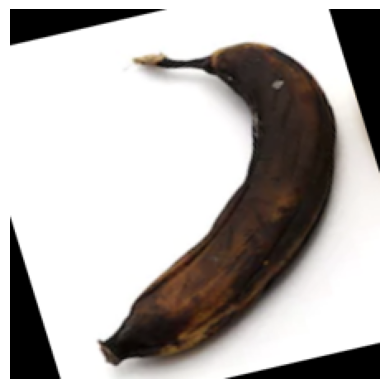

Model Prediction : Rotten (99.81%)


In [84]:
from PIL import Image
import io
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import sys
import contextlib

# Set your model's expected input size
IMG_SIZE = (224, 224)  # Change if needed

def predict_uploaded_images():
    # Suppress upload messages
    with contextlib.redirect_stdout(sys.__stdout__):
        uploaded = files.upload()

    for filename in uploaded.keys():
        # Load and preprocess image
        img = Image.open(io.BytesIO(uploaded[filename])).resize(IMG_SIZE)
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Predict
        prediction = model.predict(img_array)[0][0]
        label = "Rotten" if prediction > 0.5 else "Fresh"
        confidence = prediction if prediction > 0.5 else 1 - prediction

        # Show image
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        # Print result
        print(f"Model Prediction : {label} ({confidence * 100:.2f}%)")

# Run this to upload and predict
predict_uploaded_images()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


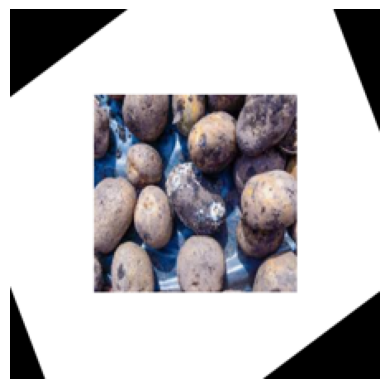

Model Prediction : Rotten (92.51%)


In [85]:
from PIL import Image
import io
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import sys
import contextlib

# Set your model's expected input size
IMG_SIZE = (224, 224)  # Change if needed

def predict_uploaded_images():
    # Suppress upload messages
    with contextlib.redirect_stdout(sys.__stdout__):
        uploaded = files.upload()

    for filename in uploaded.keys():
        # Load and preprocess image
        img = Image.open(io.BytesIO(uploaded[filename])).resize(IMG_SIZE)
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Predict
        prediction = model.predict(img_array)[0][0]
        label = "Rotten" if prediction > 0.5 else "Fresh"
        confidence = prediction if prediction > 0.5 else 1 - prediction

        # Show image
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        # Print result
        print(f"Model Prediction : {label} ({confidence * 100:.2f}%)")

# Run this to upload and predict
predict_uploaded_images()
